In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('display', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,21.0,-1,0,0,0,weekday,0.000058
1,2019-12-23 00:00:10,21.0,-1,0,0,0,weekday,0.000058
2,2019-12-23 00:00:20,21.0,-1,0,0,0,weekday,0.000058
3,2019-12-23 00:00:30,21.0,-1,0,0,0,weekday,0.000058
4,2019-12-23 00:00:40,21.0,-1,0,0,0,weekday,0.000058
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,58.0,23,6,23,59,holiday,0.000161
1451516,2020-06-07 23:59:20,58.0,23,6,23,59,holiday,0.000161
1451517,2020-06-07 23:59:30,57.5,23,6,23,59,holiday,0.000160
1451518,2020-06-07 23:59:40,57.0,23,6,23,59,holiday,0.000158


In [5]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [7]:
# subset data until lockdown 23/03/2020  (13 weeks * 7day * 48 points =4368)
subset = 4368
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [8]:
# split into train and test sets
train_size = int(len(train_test) * 0.65)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

2839 1529


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
look_back=48
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [32]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(100, input_dim=look_back, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history=model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 2s - loss: 28.8482 - mse: 28.8482 - mae: 2.5239 - mape: 222889536.0000
Epoch 2/200
 - 1s - loss: 17.7187 - mse: 17.7187 - mae: 1.8739 - mape: 181689920.0000
Epoch 3/200
 - 1s - loss: 16.0283 - mse: 16.0284 - mae: 1.7421 - mape: 148112912.0000
Epoch 4/200
 - 1s - loss: 14.9121 - mse: 14.9120 - mae: 1.6203 - mape: 128990456.0000
Epoch 5/200
 - 1s - loss: 14.4840 - mse: 14.4840 - mae: 1.5874 - mape: 145229328.0000
Epoch 6/200
 - 1s - loss: 13.9025 - mse: 13.9025 - mae: 1.5112 - mape: 127694640.0000
Epoch 7/200
 - 1s - loss: 13.3491 - mse: 13.3491 - mae: 1.4568 - mape: 106987896.0000
Epoch 8/200
 - 1s - loss: 13.4757 - mse: 13.4758 - mae: 1.4756 - mape: 134415824.0000
Epoch 9/200
 - 1s - loss: 13.3916 - mse: 13.3916 - mae: 1.4495 - mape: 132225672.0000
Epoch 10/200
 - 1s - loss: 13.0876 - mse: 13.0876 - mae: 1.4386 - mape: 122320128.0000
Epoch 11/200
 - 1s - loss: 12.7510 - mse: 12.7510 - mae: 1.4038 - mape: 123218448.0000
Epoch 12/200
 - 1s - loss: 12.2491 - mse: 12.2491 - 

Epoch 98/200
 - 1s - loss: 2.9414 - mse: 2.9414 - mae: 0.6836 - mape: 72255216.0000
Epoch 99/200
 - 1s - loss: 3.8694 - mse: 3.8694 - mae: 0.7383 - mape: 67502024.0000
Epoch 100/200
 - 1s - loss: 3.3534 - mse: 3.3534 - mae: 0.7330 - mape: 74864720.0000
Epoch 101/200
 - 1s - loss: 3.2158 - mse: 3.2158 - mae: 0.7088 - mape: 68500704.0000
Epoch 102/200
 - 1s - loss: 2.8487 - mse: 2.8487 - mae: 0.6661 - mape: 69788384.0000
Epoch 103/200
 - 1s - loss: 3.2052 - mse: 3.2052 - mae: 0.7084 - mape: 76283288.0000
Epoch 104/200
 - 1s - loss: 3.1766 - mse: 3.1766 - mae: 0.6987 - mape: 70137096.0000
Epoch 105/200
 - 1s - loss: 3.2247 - mse: 3.2247 - mae: 0.6997 - mape: 68675952.0000
Epoch 106/200
 - 2s - loss: 3.1452 - mse: 3.1452 - mae: 0.6950 - mape: 63971904.0000
Epoch 107/200
 - 2s - loss: 3.6974 - mse: 3.6974 - mae: 0.7320 - mape: 80032280.0000
Epoch 108/200
 - 2s - loss: 2.9584 - mse: 2.9584 - mae: 0.6760 - mape: 69662424.0000
Epoch 109/200
 - 2s - loss: 3.1109 - mse: 3.1109 - mae: 0.6743 - ma

Epoch 195/200
 - 2s - loss: 2.1402 - mse: 2.1402 - mae: 0.5511 - mape: 59492500.0000
Epoch 196/200
 - 2s - loss: 2.3436 - mse: 2.3436 - mae: 0.5776 - mape: 56569748.0000
Epoch 197/200
 - 2s - loss: 2.1499 - mse: 2.1499 - mae: 0.5463 - mape: 47838016.0000
Epoch 198/200
 - 1s - loss: 2.5004 - mse: 2.5004 - mae: 0.5772 - mape: 65130944.0000
Epoch 199/200
 - 1s - loss: 2.3745 - mse: 2.3745 - mae: 0.5656 - mape: 56894744.0000
Epoch 200/200
 - 1s - loss: 2.4026 - mse: 2.4026 - mae: 0.5802 - mape: 54492692.0000


In [33]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])

1480/1480 [==============================] - 0s 29us/step
Train MSE:  1.7596209049224854 MAE:  0.45055827498435974
Test MSE:  24.05756378173828 MAE:  2.189781665802002


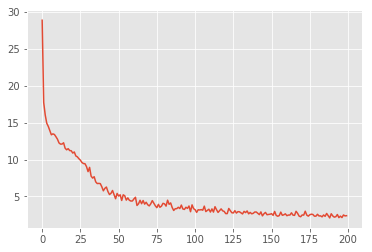

In [34]:
plt.plot(history.history['loss'])

In [35]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [36]:
print(nextPredict,df_simu[0:1].values)

[[26.446104]] [[28.98888889]]


In [37]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.8934883324952221

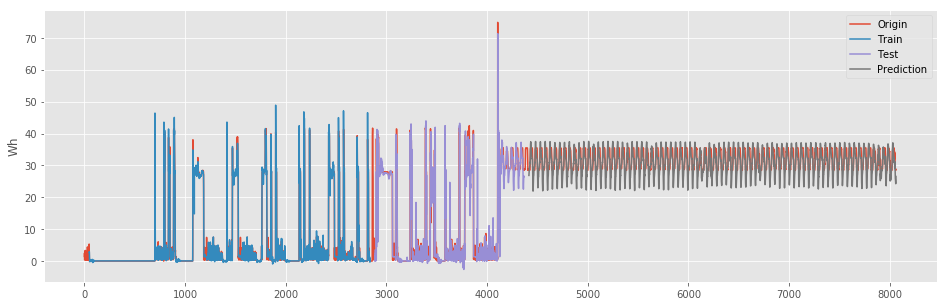

In [38]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [39]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

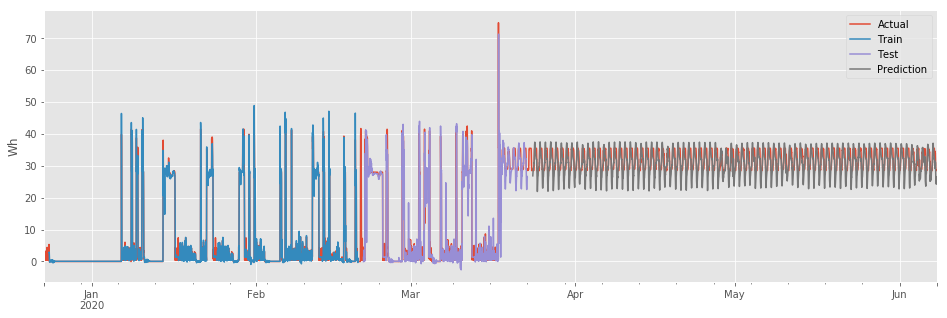

In [40]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

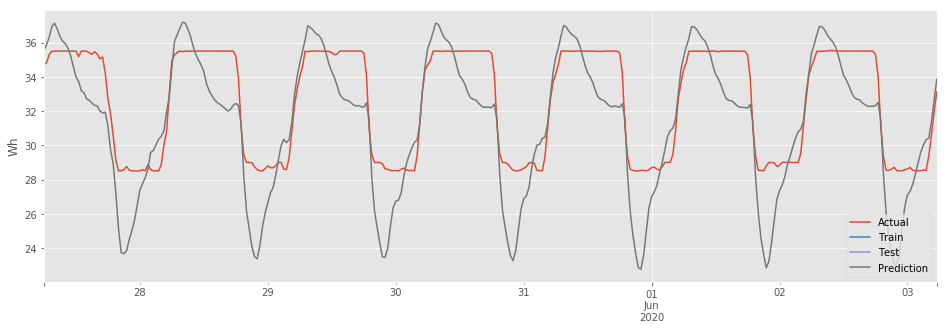

In [41]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

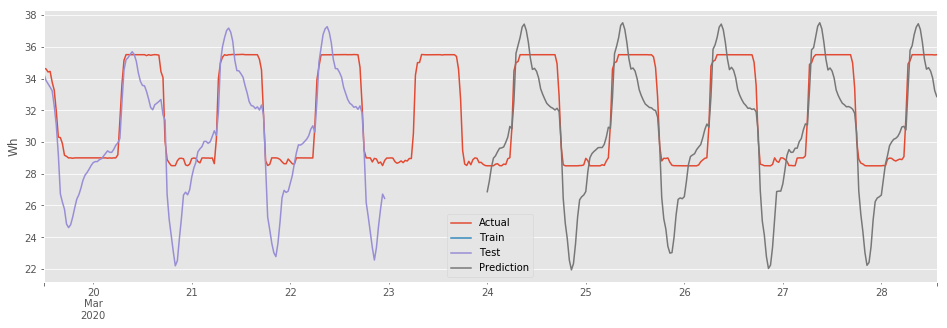

In [42]:
df_all_plot[4200:4636].set_index(df_all_plot[4200:4636].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

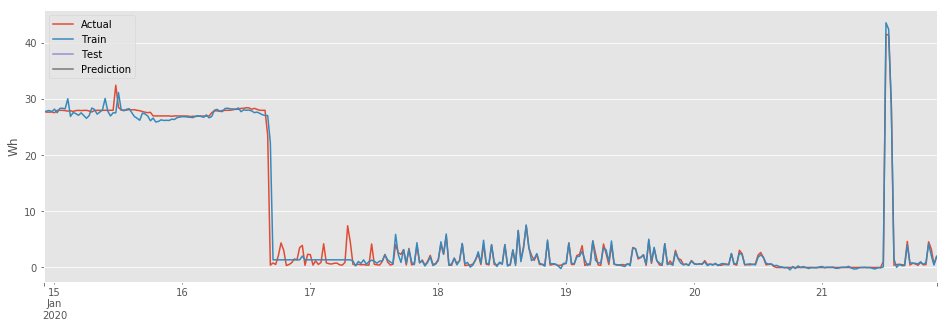

In [43]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [44]:
# save the model 
model.save('display_nolock_ann.h5')

In [6]:
# with lockdown
mad_mean_ratio =2.19*1529/df_half['Half_Wh'][4368-1529:4368].sum() 
mad_mean_ratio

0.16311386372255351